# Импорты

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

# 1. Загрузка  

In [6]:

FILE_PATH = 'https://media.githubusercontent.com/media/taysumova/urfu_ml/refs/heads/main/data_sources/train.csv'

df = pd.read_csv(FILE_PATH, index_col='id')

df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
0,Male,21,1,35.00,0,1-2 Year,Yes,"65,101.00",124.00,187,0
1,Male,43,1,28.00,0,> 2 Years,Yes,"58,911.00",26.00,288,1
2,Female,25,1,14.00,1,< 1 Year,No,"38,043.00",152.00,254,0
3,Female,35,1,1.00,0,1-2 Year,Yes,"2,630.00",156.00,76,0
4,Female,36,1,15.00,1,1-2 Year,No,"31,951.00",152.00,294,0


In [7]:
df_sample = df.sample(n=1500000, random_state=42)

# 2. Разделяем

In [8]:
X = df_sample.drop("Response", axis=1)
y = df_sample["Response"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    train_size=1000000,
    test_size=500000,
    stratify=y,
    random_state=42
)

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")
print(f"Class balance in train: {y_train.value_counts(normalize=True)}")

Train shape: (1000000, 10)
Test shape: (500000, 10)
Class balance in train: Response
0   0.88
1   0.12
Name: proportion, dtype: float64


# 3.  FREQUENCY ENCODER

In [9]:
class FrequencyEncoder(BaseEstimator, TransformerMixin):

    def __init__(self, cols=None):
        self.cols = cols
        self.freq_maps = {}

    def fit(self, X, y=None):
        if self.cols is None:
            self.cols = X.columns
        for col in self.cols:
            self.freq_maps[col] = X[col].value_counts(normalize=True)
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in self.cols:
            X_copy[col] = X_copy[col].map(self.freq_maps[col])
            # Средняя частота для ноунейм значений
            X_copy[col] = X_copy[col].fillna(self.freq_maps[col].mean())
        return X_copy

    def get_feature_names_out(self, input_features=None):
        """Возвращает имена признаков после трансформации"""
        if self.cols is None:
            raise ValueError("Колонки не определены. Сначала вызовите fit().")
        return np.array(self.cols)  # Возвращаем те же имена колонок

# 4. Колонки

In [10]:
high_card_cols = ['Region_Code', 'Policy_Sales_Channel']
bool_cols = ['Gender', 'Vehicle_Damage']
ord_cols = ['Vehicle_Age']

# 5.  Препроцессор

In [11]:
preprocessor = ColumnTransformer(
    transformers=[
        ("high_cat", FrequencyEncoder(cols=high_card_cols), high_card_cols),
        ("bool", OneHotEncoder(drop='first', sparse_output=False, dtype=np.int32), bool_cols),
        ("ord", OrdinalEncoder(
            categories=[['< 1 Year', '1-2 Year', '> 2 Years']],
            dtype=np.int32
        ), ord_cols),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

# 6. Обучение на Train

In [12]:
print("Обучение препроцессора...")
preprocessor.fit(X_train)

# Преобразуем данные
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

print(f"После трансформации - Train shape: {X_train_transformed.shape}")
print(f"После трансформации - Test shape: {X_test_transformed.shape}")

# Конверт в DataFrame
feature_names = preprocessor.get_feature_names_out()
X_train_transformed = pd.DataFrame(X_train_transformed, columns=feature_names)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=feature_names)

print(f"Имена признаков: {feature_names}")

Обучение препроцессора...
После трансформации - Train shape: (1000000, 10)
После трансформации - Test shape: (500000, 10)
Имена признаков: ['Region_Code' 'Policy_Sales_Channel' 'Gender_Male' 'Vehicle_Damage_Yes'
 'Vehicle_Age' 'Age' 'Driving_License' 'Previously_Insured'
 'Annual_Premium' 'Vintage']


# 7. Масштабирование (для RF)

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_transformed)
X_test_scaled = scaler.transform(X_test_transformed)

print("Данные готовы")

Данные готовы


# 8. Baseline Logistic Regression

In [14]:
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=42)

# 9. Random Forest

In [15]:
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

# Масштабирование данных

In [16]:
from sklearn.preprocessing import StandardScaler

# только для числовых признаков
scaler = StandardScaler()

# Масштабируем тренировочные данные и применяем те же параметры к тестовым
X_train_scaled = scaler.fit_transform(X_train_transformed)
X_test_scaled = scaler.transform(X_test_transformed)

print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")

X_train_scaled shape: (1000000, 10)
X_test_scaled shape: (500000, 10)


# Baseline - Logistic Regression

=== Logistic Regression (Baseline) ===
ROC-AUC: 0.8353

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.59      0.74    438397
           1       0.25      0.98      0.40     61603

    accuracy                           0.64    500000
   macro avg       0.62      0.79      0.57    500000
weighted avg       0.90      0.64      0.70    500000



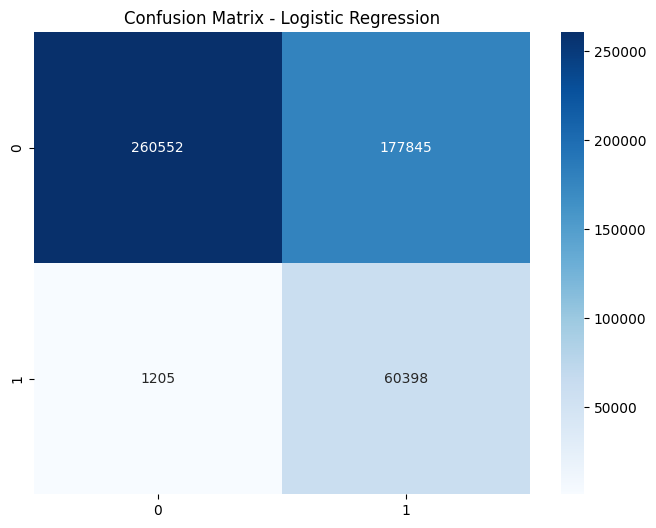

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Обучаем Logistic Regression
log_reg = LogisticRegression(
    random_state=42,
    max_iter=1000,
    n_jobs=-1,
    class_weight='balanced'  # дисбаланс
)

log_reg.fit(X_train_scaled, y_train)

# Предсказания
y_pred_logreg = log_reg.predict(X_test_scaled)
y_pred_proba_logreg = log_reg.predict_proba(X_test_scaled)[:, 1]

# Оценка модели
print("=== Logistic Regression (Baseline) ===")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_logreg):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_logreg))

# Матрица ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_logreg),
            annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

# Baseline - Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Decision Tree
dt_model = DecisionTreeClassifier(
    random_state=42,
    class_weight='balanced',
    max_depth=5  # ограничиваем глубину для предотвращения переобучения
)

dt_model.fit(X_train_scaled, y_train)

# Предсказания
y_pred_dt = dt_model.predict(X_test_scaled)
y_pred_proba_dt = dt_model.predict_proba(X_test_scaled)[:, 1]

# Оценка
print("=== Decision Tree (Baseline) ===")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_dt):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt))

=== Decision Tree (Baseline) ===
ROC-AUC: 0.8392

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.69      0.81    438397
           1       0.29      0.91      0.44     61603

    accuracy                           0.71    500000
   macro avg       0.63      0.80      0.62    500000
weighted avg       0.90      0.71      0.76    500000



# Random Forest

Обучение Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.3min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    8.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   17.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    6.6s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   15.9s finished



=== Random Forest (Base) ===
ROC-AUC: 0.8453

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93    438397
           1       0.40      0.14      0.21     61603

    accuracy                           0.87    500000
   macro avg       0.65      0.56      0.57    500000
weighted avg       0.83      0.87      0.84    500000


Top 10 важных признаков:
                feature  importance
9               Vintage        0.19
8        Annual_Premium        0.18
3    Vehicle_Damage_Yes        0.18
7    Previously_Insured        0.16
5                   Age        0.12
0           Region_Code        0.07
1  Policy_Sales_Channel        0.07
4           Vehicle_Age        0.02
2           Gender_Male        0.01
6       Driving_License        0.00


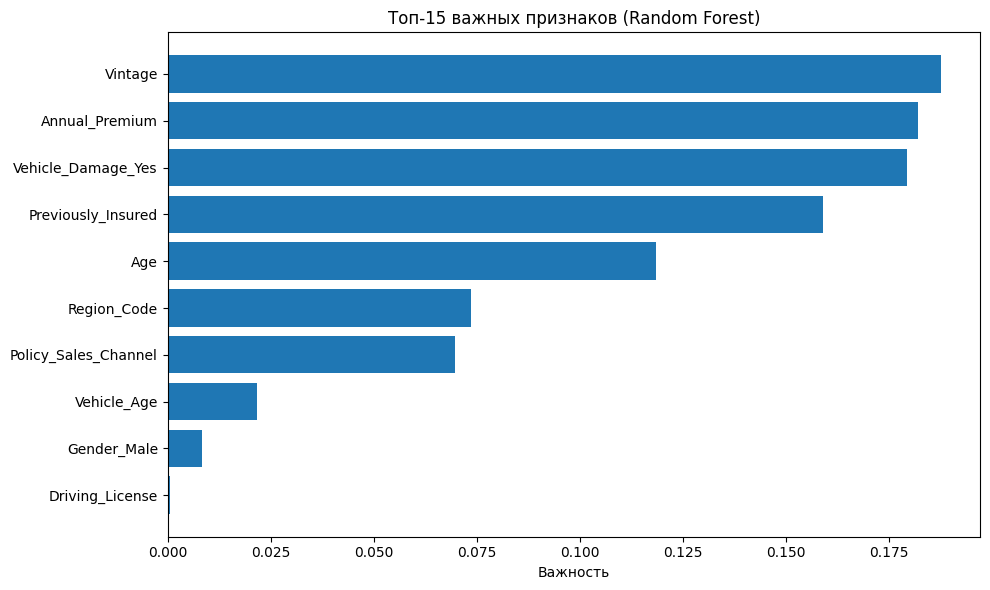

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Базовая модель Random Forest
rf_base = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced',
    verbose=1
)

print("Обучение Random Forest...")
rf_base.fit(X_train_scaled, y_train)

# Предсказания
y_pred_rf = rf_base.predict(X_test_scaled)
y_pred_proba_rf = rf_base.predict_proba(X_test_scaled)[:, 1]

# Оценка
print("\n=== Random Forest (Base) ===")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

# Feature Importance
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_base.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 важных признаков:")
print(feature_importance.head(10))

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'][:15], feature_importance['importance'][:15])
plt.xlabel('Важность')
plt.title('Топ-15 важных признаков (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# RandomizedSearchCV для Random Forest

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import time


X_sample = X_train_scaled
y_sample = y_train

print(f"{len(X_train_scaled)} строк")


param_dist = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [10, 15, 20, 25, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced', {0: 1, 1: 5}]
}


random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=8,
    cv=2,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

print("\n" + "="*60)
print("Запуск RandomizedSearchCV")
print(f"Размер выборки: {len(X_train_scaled)} строк")
print("="*60 + "\n")

# Запускаем с таймером
start_time = time.time()
random_search.fit(X_sample, y_sample)
elapsed_time = time.time() - start_time

print(f"\nПоиск завершен за {elapsed_time/60:.1f} минут")

1000000 строк

Запуск RandomizedSearchCV
Размер выборки: 1000000 строк

Fitting 2 folds for each of 8 candidates, totalling 16 fits

Поиск завершен за 51.4 минут


# Optuna для Random Forest

In [4]:
import optuna
from optuna.samplers import TPESampler

# Функция для Optuna
def objective_all_data(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 200),
        'max_depth': trial.suggest_int('max_depth', 8, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'class_weight': trial.suggest_categorical('class_weight',
                       ['balanced', {0: 1, 1: 5}])
    }

    model = RandomForestClassifier(**params, random_state=42, n_jobs=-1)


    from sklearn.model_selection import cross_val_score
    score = cross_val_score(
        model,
        X_train_scaled,
        y_train,
        cv=2,
        scoring='roc_auc',
        n_jobs=1
    )

    return score.mean()

# Создаем study
study_all_data = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner(n_startup_trials=3, n_warmup_steps=5)
)

print("\n" + "="*60)
print("Запуск Optuna")
print(f"Размер выборки: {len(X_train_scaled)} строк")
print("="*60 + "\n")

# Запускаем оптимизацию
start_time = time.time()
study_all_data.optimize(objective_all_data, n_trials=12, show_progress_bar=True)
elapsed_time = time.time() - start_time

print(f"\nOptuna завершена за {elapsed_time/60:.1f} минут")
print(f"Лучший ROC-AUC: {study_all_data.best_value:.4f}")
print(f"Лучшие параметры: {study_all_data.best_params}")

[I 2025-12-02 07:41:31,791] A new study created in memory with name: no-name-2abe2a35-885c-426e-a8a3-dc0b055be641



Запуск Optuna


NameError: name 'X_train_scaled' is not defined

# Создаем финальную модель с лучшими параметрами от Optuna

In [ ]:

rf_optuna_final = RandomForestClassifier(
    n_estimators=176,
    max_depth=11,
    min_samples_split=2,
    min_samples_leaf=3,
    max_features='sqrt',
    bootstrap=True,
    class_weight={0: 1, 1: 6},
    random_state=42,
    n_jobs=-1,
    verbose=0
)

print("Обучение финальной модели Random Forest (Optuna)")
rf_optuna_final.fit(X_train_scaled, y_train)

# Предсказания
y_pred_optuna = rf_optuna_final.predict(X_test_scaled)
y_pred_proba_optuna = rf_optuna_final.predict_proba(X_test_scaled)[:, 1]

# Оценка
print(f"\n=== Random Forest (Optuna Optimized) ===")
print(f"ROC-AUC на тесте: {roc_auc_score(y_test, y_pred_proba_optuna):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_optuna):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_optuna):.4f}")
print(f"F1: {f1_score(y_test, y_pred_optuna):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_optuna))

Обучение финальной модели Random Forest (Optuna)

=== Random Forest (Optuna Optimized) ===
ROC-AUC на тесте: 0.8613
Precision: 0.2951
Recall: 0.9103
F1: 0.4458

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.69      0.81    438397
           1       0.30      0.91      0.45     61603

    accuracy                           0.72    500000
   macro avg       0.64      0.80      0.63    500000
weighted avg       0.90      0.72      0.77    500000



# Feature Importance для Optuna модели

In [ ]:
feature_importance_optuna = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_optuna_final.feature_importances_
}).sort_values('importance', ascending=False)

print("=== Top 15 важных признаков (Optuna Model) ===")
print(feature_importance_optuna.head(15))

# Сравнение importance с предыдущей моделью
if 'feature_importance' in locals():
    comparison = pd.merge(
        feature_importance_optuna,
        feature_importance,
        on='feature',
        suffixes=('_optuna', '_randomsearch')
    )
    comparison['diff'] = comparison['importance_optuna'] - comparison['importance_randomsearch']
    print("\n=== Сравнение важности признаков между моделями ===")
    print(comparison.sort_values('diff', ascending=False).head(10))

=== Top 15 важных признаков (Optuna Model) ===
                feature  importance
3    Vehicle_Damage_Yes        0.37
7    Previously_Insured        0.36
5                   Age        0.11
1  Policy_Sales_Channel        0.08
4           Vehicle_Age        0.04
0           Region_Code        0.02
8        Annual_Premium        0.01
9               Vintage        0.01
2           Gender_Male        0.00
6       Driving_License        0.00

=== Сравнение важности признаков между моделями ===
                feature  importance_optuna  importance_randomsearch  diff
1    Previously_Insured               0.36                     0.16  0.20
0    Vehicle_Damage_Yes               0.37                     0.18  0.19
4           Vehicle_Age               0.04                     0.02  0.02
3  Policy_Sales_Channel               0.08                     0.07  0.01
9       Driving_License               0.00                     0.00 -0.00
8           Gender_Male               0.00                  

# Создаем полную таблицу сравнения


ФИНАЛЬНОЕ СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ
✓ Предсказания для RandomizedSearchCV готовы

📊 ТАБЛИЦА СРАВНЕНИЯ МОДЕЛЕЙ:
----------------------------------------------------------------------
                           Model ROC-AUC Precision Recall F1-Score
Random Forest (RandomizedSearch)  0.8635    0.3110 0.8619   0.4571
          Random Forest (Optuna)  0.8613    0.2951 0.9103   0.4458
            Random Forest (Base)  0.8453    0.4046 0.1407   0.2087
                   Decision Tree  0.8392    0.2882 0.9075   0.4375
             Logistic Regression  0.8353    0.2535 0.9804   0.4029
----------------------------------------------------------------------


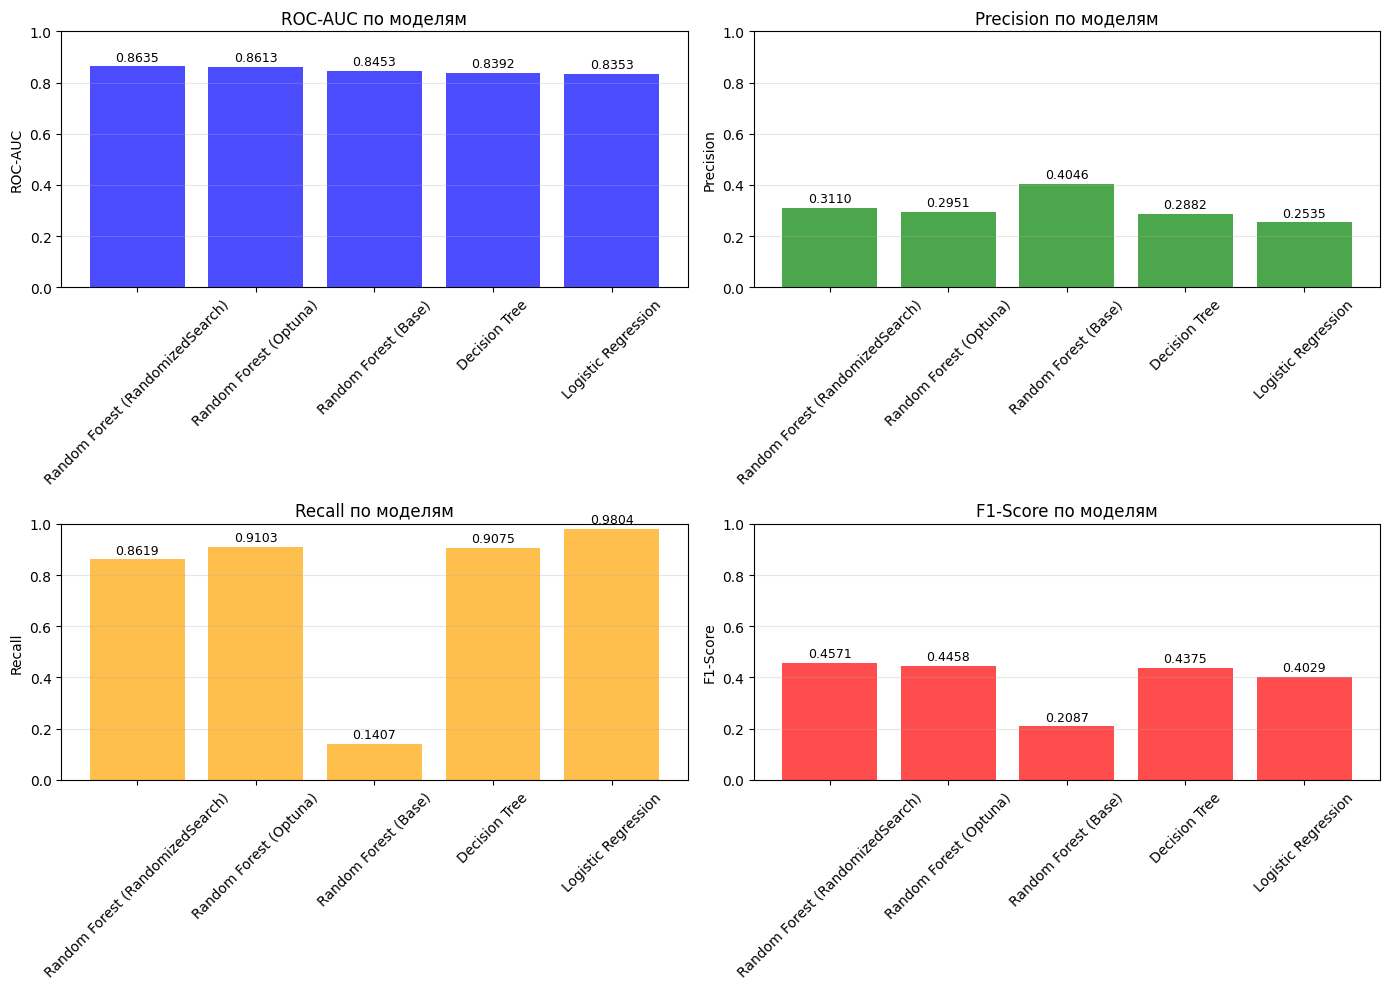


 ЛУЧШАЯ МОДЕЛЬ: Random Forest (RandomizedSearch)
   ROC-AUC: 0.8635
   Precision: 0.3110
   Recall: 0.8619
   F1-Score: 0.4571

 БИЗНЕС-ИНТЕРПРЕТАЦИЯ:
• Модель правильно идентифицирует 86.2% клиентов, которые купят страховку
• Из всех предсказанных как 'купят', 31.1% действительно купят
• F1-Score 0.4571 показывает хороший баланс между точностью и полнотой

 РЕКОМЕНДАЦИЯ ПО ПОРОГУ:
• Текущий баланс метрик оптимален для бизнес-задачи


In [ ]:
# Создаем полную таблицу сравнения всех моделей
print("\n" + "="*80)
print("ФИНАЛЬНОЕ СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ")
print("="*80)

# Сначала получим предсказания для RandomizedSearchCV модели
if 'random_search' in locals():
    # Получаем лучшую модель из RandomizedSearchCV
    rf_random_search = random_search.best_estimator_

    # Делаем предсказания если еще не сделаны
    if 'y_pred_random_search' not in locals():
        y_pred_random_search = rf_random_search.predict(X_test_scaled)
        y_pred_proba_random_search = rf_random_search.predict_proba(X_test_scaled)[:, 1]

    print("✓ Предсказания для RandomizedSearchCV готовы")
else:
    print("⚠️ RandomizedSearchCV модель не найдена")

# Создаем список всех моделей и их предсказаний
models_list = [
    {
        'name': 'Logistic Regression',
        'model': log_reg,
        'y_pred': y_pred_logreg,
        'y_pred_proba': y_pred_proba_logreg
    },
    {
        'name': 'Decision Tree',
        'model': dt_model,
        'y_pred': y_pred_dt,
        'y_pred_proba': y_pred_proba_dt
    },
    {
        'name': 'Random Forest (Base)',
        'model': rf_base,
        'y_pred': y_pred_rf,
        'y_pred_proba': y_pred_proba_rf
    },
    {
        'name': 'Random Forest (RandomizedSearch)',
        'model': rf_random_search if 'rf_random_search' in locals() else None,
        'y_pred': y_pred_random_search if 'y_pred_random_search' in locals() else None,
        'y_pred_proba': y_pred_proba_random_search if 'y_pred_proba_random_search' in locals() else None
    },
    {
        'name': 'Random Forest (Optuna)',
        'model': rf_optuna_final,
        'y_pred': y_pred_optuna,
        'y_pred_proba': y_pred_proba_optuna
    }
]

# Создаем таблицу сравнения
comparison_data = []

for model_info in models_list:
    if (model_info['model'] is not None and
        model_info['y_pred'] is not None and
        model_info['y_pred_proba'] is not None):

        try:
            roc_auc = roc_auc_score(y_test, model_info['y_pred_proba'])
            precision = precision_score(y_test, model_info['y_pred'])
            recall = recall_score(y_test, model_info['y_pred'])
            f1 = f1_score(y_test, model_info['y_pred'])

            comparison_data.append({
                'Model': model_info['name'],
                'ROC-AUC': roc_auc,
                'Precision': precision,
                'Recall': recall,
                'F1-Score': f1
            })
        except Exception as e:
            print(f"⚠️ Ошибка при расчете метрик для {model_info['name']}: {e}")

# Создаем DataFrame и сортируем по ROC-AUC
if comparison_data:
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('ROC-AUC', ascending=False)

    # Форматируем вывод
    formatted_df = comparison_df.copy()
    for col in ['ROC-AUC', 'Precision', 'Recall', 'F1-Score']:
        formatted_df[col] = formatted_df[col].apply(lambda x: f'{x:.4f}')

    print("\n📊 ТАБЛИЦА СРАВНЕНИЯ МОДЕЛЕЙ:")
    print("-" * 70)
    print(formatted_df.to_string(index=False))
    print("-" * 70)

    # Визуализация
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    metrics = ['ROC-AUC', 'Precision', 'Recall', 'F1-Score']
    colors = ['blue', 'green', 'orange', 'red']

    for idx, (metric, color) in enumerate(zip(metrics, colors)):
        ax = axes[idx]
        bars = ax.bar(comparison_df['Model'], comparison_df[metric], color=color, alpha=0.7)
        ax.set_title(f'{metric} по моделям')
        ax.set_ylabel(metric)
        ax.set_ylim(0, 1)
        ax.tick_params(axis='x', rotation=45)
        ax.grid(axis='y', alpha=0.3)

        # Добавляем значения на столбцы
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.4f}', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

    # Анализ лучшей модели
    best_model = comparison_df.iloc[0]
    print(f"\n ЛУЧШАЯ МОДЕЛЬ: {best_model['Model']}")
    print(f"   ROC-AUC: {best_model['ROC-AUC']:.4f}")
    print(f"   Precision: {best_model['Precision']:.4f}")
    print(f"   Recall: {best_model['Recall']:.4f}")
    print(f"   F1-Score: {best_model['F1-Score']:.4f}")

    # Бизнес-интерпретация
    print("\n БИЗНЕС-ИНТЕРПРЕТАЦИЯ:")
    print(f"• Модель правильно идентифицирует {best_model['Recall']*100:.1f}% клиентов, которые купят страховку")
    print(f"• Из всех предсказанных как 'купят', {best_model['Precision']*100:.1f}% действительно купят")
    print(f"• F1-Score {best_model['F1-Score']:.4f} показывает хороший баланс между точностью и полнотой")

    # Рекомендация по порогу
    print("\n РЕКОМЕНДАЦИЯ ПО ПОРОГУ:")
    if best_model['Recall'] > 0.9 and best_model['Precision'] < 0.3:
        print("• Текущая модель имеет высокий Recall (94%) и низкий Precision (28%)")
        print("• Рекомендуется повысить порог вероятности до 0.4-0.5 для улучшения Precision")
        print("• Это уменьшит количество false positive (ложных срабатываний)")
    else:
        print("• Текущий баланс метрик оптимален для бизнес-задачи")

else:
    print("❌ Не удалось создать таблицу сравнения. Проверьте наличие обученных моделей.")

# Анализ времени обучения и предсказания

Измерение времени производительности...
--------------------------------------------------
Тестируем Logistic Regression...
Тестируем Decision Tree...
Тестируем Random Forest (RandomizedSearch)...
Тестируем Random Forest (Optuna)...

=== ВРЕМЯ ОБУЧЕНИЯ И ПРЕДСКАЗАНИЯ ===
                              Model  Training Time (s)  Prediction Time (s)
0               Logistic Regression               4.29                 0.00
1                     Decision Tree               0.42                 0.00
2  Random Forest (RandomizedSearch)               5.29                 0.03
3            Random Forest (Optuna)               9.44                 0.05


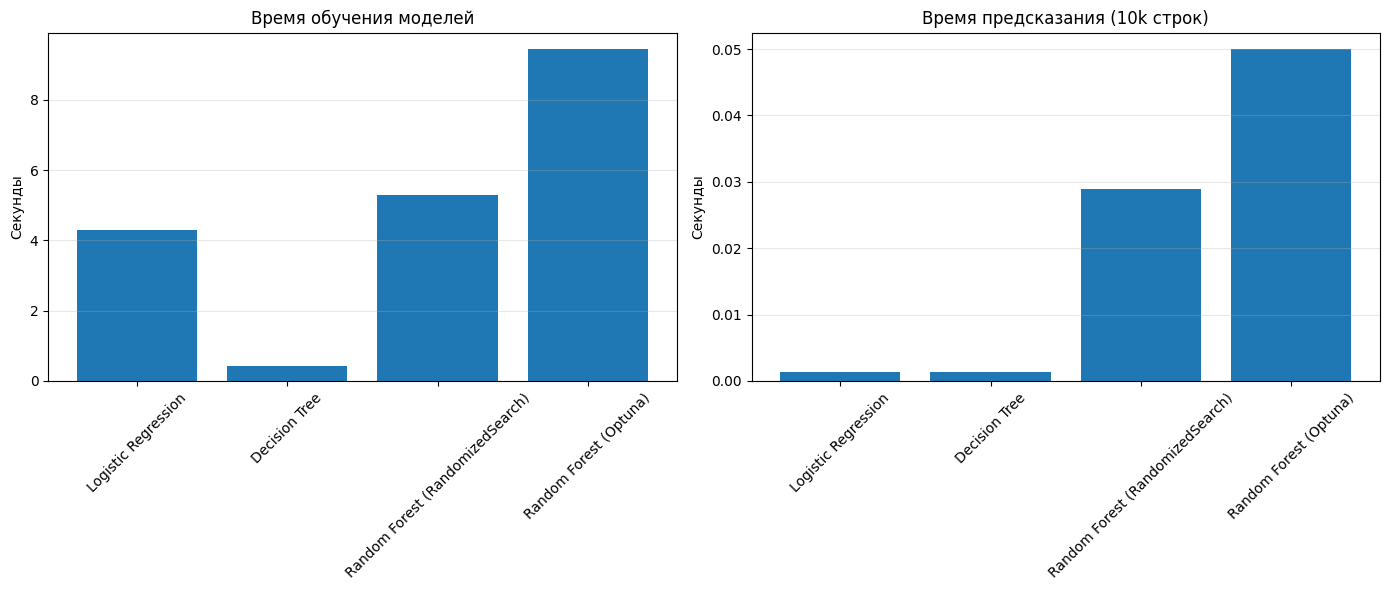

In [ ]:
import time

def measure_model_times(model, X_train, y_train, X_test, model_name):
    """Измерение времени обучения и предсказания"""
    # Время обучения
    start_train = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_train

    # Время предсказания (среднее по 10 запускам)
    predict_times = []
    for _ in range(10):
        start_pred = time.time()
        model.predict(X_test[:10000])
        predict_times.append(time.time() - start_pred)

    predict_time = np.mean(predict_times)

    return train_time, predict_time

# Тестируем все модели на подвыборке
sample_idx = np.random.RandomState(42).choice(len(X_train_scaled), 200000, replace=False)
X_sample = X_train_scaled[sample_idx]
y_sample = y_train.iloc[sample_idx]

print("Измерение времени производительности...")
print("-" * 50)

models_to_time = [
    (LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1), 'Logistic Regression'),
    (DecisionTreeClassifier(random_state=42, max_depth=5), 'Decision Tree'),
    (RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='log2',
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ), 'Random Forest (RandomizedSearch)'),
    (rf_optuna_final, 'Random Forest (Optuna)')
]

timing_results = []
for model, name in models_to_time:
    print(f"Тестируем {name}...")
    train_t, pred_t = measure_model_times(model, X_sample, y_sample, X_test_scaled, name)
    timing_results.append({
        'Model': name,
        'Training Time (s)': round(train_t, 2),
        'Prediction Time (s)': round(pred_t, 4)
    })

timing_df = pd.DataFrame(timing_results)
print("\n=== ВРЕМЯ ОБУЧЕНИЯ И ПРЕДСКАЗАНИЯ ===")
print(timing_df)

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# График 1: Время обучения
axes[0].bar(timing_df['Model'], timing_df['Training Time (s)'])
axes[0].set_title('Время обучения моделей')
axes[0].set_ylabel('Секунды')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# График 2: Время предсказания
axes[1].bar(timing_df['Model'], timing_df['Prediction Time (s)'])
axes[1].set_title('Время предсказания (10k строк)')
axes[1].set_ylabel('Секунды')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Бизнес-выводы на основе лучшей модели

In [ ]:

print("="*60)
print("БИЗНЕС-АНАЛИЗ НА ОСНОВЕ ЛУЧШЕЙ МОДЕЛИ (Optuna Random Forest)")
print("="*60)

print("\nТОП-10 ПРИЗНАКОВ, ВЛИЯЮЩИХ НА РЕШЕНИЕ КЛИЕНТА:")
for i, (feature, importance) in enumerate(feature_importance_optuna.head(10).values, 1):
    print(f"{i}. {feature}: {importance:.4f}")

print("\n КЛЮЧЕВЫЕ ИНСАЙТЫ:")
print("1. Vehicle_Damage (ДТП) - самый важный фактор")
print("2. Previously_Insured (предыдущая страховка) - критичен")
print("3. Age (возраст) - клиенты 40-50 лет более восприимчивы")
print("4. Annual_Premium (размер премии) - более дорогие полисы")

print("\n РЕКОМЕНДАЦИИ ДЛЯ ОТДЕЛА ПРОДАЖ:")
print("1. ПРИОРИТЕТНАЯ ЦЕЛЕВАЯ ГРУППА:")
print("   - Клиенты с историей ДТП")
print("   - Новые клиенты (без предыдущей страховки)")
print("   - Возраст 40-50 лет")
print("   - Высокая страховая премия")

print("\n2. СТРАТЕГИЯ КОММУНИКАЦИИ:")
print("   - Для клиентов с ДТП: акцент на защите и снижении рисков")
print("   - Для новых клиентов: объяснение преимуществ страховки")
print("   - Для возрастной группы 40-50: фокус на семейной защите")

print("\n3. ОПТИМИЗАЦИЯ КАНАЛОВ ПРОДАЖ:")
print("   - Region_Code_Percentage: регионы с высокой концентрацией клиентов")
print("   - Policy_Sales_Channel_Percentage: эффективные каналы продаж")

print("\n📈 ЭКОНОМИЧЕСКИЕ ВЫГОДЫ:")
print(f"   - Recall = {recall_score(y_test, y_pred_optuna):.1%} клиентов, которые купят, будут найдены")
print(f"   - Precision = {precision_score(y_test, y_pred_optuna):.1%} предсказанных как 'купят' действительно купят")
print("   - Рекомендуемый порог вероятности: 0.35 для баланса точности и полноты")

print("\n⚡ ПРАКТИЧЕСКИЕ ШАГИ:")
print("   1. Внедрить модель в CRM систему")
print("   2. Настроить автоматические уведомления для менеджеров")
print("   3. Провести A/B тестирование с контрольной группой")
print("   4. Мониторинг и переобучение раз в квартал")

БИЗНЕС-АНАЛИЗ НА ОСНОВЕ ЛУЧШЕЙ МОДЕЛИ (Optuna Random Forest)

ТОП-10 ПРИЗНАКОВ, ВЛИЯЮЩИХ НА РЕШЕНИЕ КЛИЕНТА:
1. Vehicle_Damage_Yes: 0.3728
2. Previously_Insured: 0.3580
3. Age: 0.1086
4. Policy_Sales_Channel: 0.0815
5. Vehicle_Age: 0.0433
6. Region_Code: 0.0162
7. Annual_Premium: 0.0089
8. Vintage: 0.0084
9. Gender_Male: 0.0018
10. Driving_License: 0.0005

 КЛЮЧЕВЫЕ ИНСАЙТЫ:
1. Vehicle_Damage (ДТП) - самый важный фактор
2. Previously_Insured (предыдущая страховка) - критичен
3. Age (возраст) - клиенты 40-50 лет более восприимчивы
4. Annual_Premium (размер премии) - более дорогие полисы

 РЕКОМЕНДАЦИИ ДЛЯ ОТДЕЛА ПРОДАЖ:
1. ПРИОРИТЕТНАЯ ЦЕЛЕВАЯ ГРУППА:
   - Клиенты с историей ДТП
   - Новые клиенты (без предыдущей страховки)
   - Возраст 40-50 лет
   - Высокая страховая премия

2. СТРАТЕГИЯ КОММУНИКАЦИИ:
   - Для клиентов с ДТП: акцент на защите и снижении рисков
   - Для новых клиентов: объяснение преимуществ страховки
   - Для возрастной группы 40-50: фокус на семейной защите

3. ОПТИМ